In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.SN_Curve import SN_Curve_qats
from utils.create_geo_matrix import create_geo_matrix
from utils.transformations import global_2_compass, compass_2_global
import numpy as np
import sys
import pandas as pd
import os
from utils.get_scf_sector_list import get_scf_sector_list

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [30 / 2.54, 20 / 2.54]
pd.set_option('display.width', 1000) # Print columns wider
pd.set_option('display.max_rows', 500) # Print more rows


### Pre-define data paths, global variables etc.

In [3]:
# Get relevant data_paths for DLC and simulation result files
data_path              = fr'{os.getcwd()}\data'
geometry_file          = data_path +  r'\DA_P53_CD.xlsx'
point_angles  = [float(i) for i in range(0,359,15)] 

# Extract file for all DEM sums per geo, per elevation
DEM_data_path = fr'{os.getcwd()}\output\python_combined_DEM.xlsx'
df_xlsx = pd.read_excel(DEM_data_path)

# Define DEM variables
T_lifetime = 25.0
N_equivalent = 1e7
wohler_exp = 5.0
curve = SN_Curve_qats('D')
DFF = 3.0

### Extract hotspot geometry

In [4]:
geo_test_df = pd.read_excel(fr'{os.getcwd()}\unused\DA_P53_CD copy with extra geo.xlsx')
top_boat_landing_geo = create_geo_matrix(geo_test_df, point_angles, curve)[0]
# top_boat_landing_geo = geo_test_df.iloc[0]
elevation_boat_landing = top_boat_landing_geo['elevation']

### Define angles in both turbine frame and compass frame

In [5]:
# Translate the angles to compass angles to align with given SCF factor
global_angles = [float(key) for key in df_xlsx.iloc[0][1:].keys()] # 1: due to element 0 being 'mLat'
compass_angles = global_2_compass(global_angles)
adjusted_compass_angles, scf_sectors = get_scf_sector_list(top_boat_landing_geo, compass_angles)
adjusted_global_angles = compass_2_global(adjusted_compass_angles)
validate_df = pd.DataFrame(data=np.hstack((np.array([adjusted_compass_angles]).reshape(-1,1), 
                                np.array([scf_sectors]).reshape(-1,1), 
                                np.array([adjusted_global_angles]).reshape(-1,1))), 
                                columns = ['Adjusted compass angles', 'SCF','Adjusted global angles'])

### Extract pre computed DEM data - use boat landing geometry - find member_elevations of nodes above and below boat landing

In [6]:
''' The goal here is for this script to be independent of the geometries that were used during the initial DEM-sum calculations '''
member_elevations = np.array([float(key) for key in (df_xlsx['mLat'].values)])
dist = member_elevations - elevation_boat_landing

assert (np.any(dist >= 0.)), 'Geo in question is above the highest node - invalid for interpolation'
assert (np.any(dist < 0.)), 'Geo in question is below the lowest node - invalid for interpolation'

In [7]:
idx_above = np.ma.MaskedArray(dist, dist < 0.0).argmin() # mask out values below 0, and find the positive value closest to zero
idx_below = np.ma.MaskedArray(dist, dist >= 0.0).argmax() # mask out values above 0, and find the negative value closest to zero
idx_closest = np.abs(dist).argmin()

elevation_above = member_elevations[idx_above]
elevation_below = member_elevations[idx_below]
elevation_closest = member_elevations[idx_closest]
                             
print(f'The nodes from the DEM calculation closest to boat landing at {elevation_boat_landing:.2f} mLat is \n{elevation_above:.2f} @ mLat above \n{elevation_below:.2f} @ mLat below')
closest_is_above = elevation_closest > elevation_boat_landing
closest_is_above = False
print(f'The closest of elevations is {elevation_closest}, {"above" if closest_is_above else "below"} the boat landing')

The nodes from the DEM calculation closest to boat landing at 9.69 mLat is 
11.20 @ mLat above 
6.50 @ mLat below
The closest of elevations is 11.2, above the boat landing


### Extract DEM from the neighbouring elevations

In [8]:
# Manually find DEM interpolated for 9.69 mLat by using manually chosen elevations
above_DEM = np.array(df_xlsx.iloc[idx_above][1:]) # remove the mLat dimension of the DataFrame - this will be a np.array with DEM for all (24) sectors
below_DEM = np.array(df_xlsx.iloc[idx_below][1:])

# Linear interpol; DEM_i = DEM_below + [dy/dx] * dx = DEM_below + [(delta DEM above/below) / (delta elevation above/below) ] * (elevation geo i - elevation below) or DEM_below + interpol_factor * delta DEM
interpol_factor = (elevation_boat_landing - elevation_below) / (elevation_above - elevation_below) 

## Use the interpolated DEM to calculate the factor to scale moment ranges with accordingly

In [9]:
# Calculate total DEM for above, current and below elevations, for all sectors (n_sectors, )-shaped
DEM_above_tot = ((T_lifetime / N_equivalent * above_DEM)**(1 / wohler_exp))
DEM_below_tot = ((T_lifetime / N_equivalent * below_DEM)**(1 / wohler_exp))
DEM_boat_landing_tot = DEM_below_tot + (DEM_above_tot - DEM_below_tot) * interpol_factor

### Find the reference DEM and scaling factor / scaled DEM in hotspot

In [10]:
# Find above and below
DEM_hotspot_vs_above = np.array(DEM_boat_landing_tot / DEM_above_tot) # per sector
f_hotspot_vs_above = DEM_hotspot_vs_above.max()
DEM_hotspot_vs_below = np.array(DEM_boat_landing_tot / DEM_below_tot)
f_hotspot_vs_below = DEM_hotspot_vs_below.max()

In [171]:
# Choose the reference according to closest elevation
# TODO should we choose worst, or the closest to 
# And how do we select the sector on the hotspot elevation BEFORE we know the worst DEM on that elevation? Just choose an angle with the highest SCF?

DEM_reference_factor = f_hotspot_vs_above if closest_is_above else f_hotspot_vs_below
sector_idx_for_worst_reference_DEM = DEM_hotspot_vs_above.argmax() if closest_is_above else DEM_hotspot_vs_below.argmax()
DEM_reference = DEM_above_tot[sector_idx_for_worst_reference_DEM] if closest_is_above else DEM_below_tot[sector_idx_for_worst_reference_DEM]
DEM_hotspot_interpolated = DEM_reference * DEM_reference_factor

print(f'DEM relationships above and below')
DEM_hotspot_report = 98.2 * 1.00772 * 1e6
utilization_hotspot_report = 0.799
print(f'From report: above vs. hotspot 98.2 MNm * 1.00772 ~ {DEM_hotspot_report * 1e-6:.1f} MNm')
# print(f'Above : {f_hotspot_vs_above} at ang {global_angles[DEM_hotspot_vs_above.argmax() ]} / {compass_angles[DEM_hotspot_vs_above.argmax()]} degN')
# print(f'Below: {f_hotspot_vs_below} at ang {global_angles[ DEM_hotspot_vs_below.argmax() ] } / {compass_angles[DEM_hotspot_vs_below.argmax()]} degN')
print('#'*40)
print(f'Chosing factor {"above" if closest_is_above else "below"} as reference, with reference M_eq = {DEM_reference / 10**6:.2f} MNm at {compass_angles[DEM_hotspot_vs_above.argmax()]} degN')
print(f'Interpolated DEM at hotspot with factor {DEM_reference_factor:5f} gives M_scf = {DEM_hotspot_interpolated / 10**6:.2f} MNm')
fff = DEM_hotspot_interpolated / DEM_hotspot_report
print(f'Our Meq_hotspot as a fraction of report: {fff * 100:.4f} %')
print(f'Expecting our damage to be a factor f^m = {((fff)**wohler_exp):.4f} of the report at {utilization_hotspot_report * 100:.1f} %')
print(f'so our results should be close to {utilization_hotspot_report * (fff)**wohler_exp * 100:.1f} % util (m=5), possibly up to {utilization_hotspot_report * (fff)**3.0 * 100:.1f} % util (m=3')

DEM relationships above and below
From report: above vs. hotspot 98.2 MNm * 1.00772 ~ 99.0 MNm
########################################
Chosing factor above as reference, with reference M_eq = 96.46 MNm at 180.0 degN
Interpolated DEM at hotspot with factor 1.012851 gives M_scf = 97.70 MNm
Our Meq_hotspot as a fraction of report: 98.7317 %
Expecting our damage to be a factor f^m = 0.9382 of the report at 79.9 %
so our results should be close to 75.0 % util (m=5), possibly up to 76.9 % util (m=3


## Load the markov matrices with moment ranges and counts

In [12]:
# Load the markov matrices
from utils.fastnumpyio import load as fastio_load 
markov_path = fr'{os.getcwd()}\output\total_markov_member' + '{}.npy'
mbr_to_el_map = {54: 22.4, 72: 11.2, 84: 6.5, 91: 4.275} # TODO this should be handled by the geometry file
markov_matrices = {}
for mbr in mbr_to_el_map.keys():
    path = markov_path.format(mbr)
    markov_matrices[mbr_to_el_map[mbr]] = np.array(fastio_load(path))

### Pick the markov matrix from the reference node, AT THE WORST SECTOR

In [13]:
reference_elevation = elevation_above if closest_is_above else elevation_below
markov_at_reference_elevation = markov_matrices[reference_elevation]
markov_reference = markov_at_reference_elevation[sector_idx_for_worst_reference_DEM]
markov_reference = markov_reference[ markov_reference[:, 0].argsort()]

### Check if it is possible to recreate the DEM at the reference elevation with the loaded ranges

In [14]:
reference_moment_ranges = markov_reference[:,[0]]
reference_counts = markov_reference[:,[1]]
DEM_reference_recreated = float((T_lifetime / N_equivalent * ((reference_moment_ranges.T)**wohler_exp).dot(reference_counts))**(1 / wohler_exp))

print(f'Recreated stats from the reference markov matrix at {elevation_closest:.2f} mLat:')
print(f'Total counts over {T_lifetime:.0f} years: {reference_counts.sum() * T_lifetime / 10**6:.2f} * 10^6')
print(f'Total bins with nonzero counts: {np.count_nonzero(reference_counts)}')
print(f'Smallest M_range: {reference_moment_ranges.min() * 1e-6:.2f} MNm') 
print(f'Median M_range: {np.median(reference_moment_ranges) * 1e-6:.2f} MNm') 
print(f'Largest M_range: {reference_moment_ranges.max() * 1e-6:.2f} MNm') 
print(f'Recreated DEM at reference for m = 5: {(DEM_reference_recreated) / 10**6 :.2f} MNm')
print(f'Original DEM at reference for m = 5: {DEM_reference / 10**6 :.2f} MNm')
print(f'It is {"possible" if ((DEM_reference - DEM_reference_recreated) < 1e-6) else "not possible"} to recreate DEM')

Recreated stats from the reference markov matrix at 11.20 mLat:
Total counts over 25 years: 163.97 * 10^6
Total bins with nonzero counts: 745768
Smallest M_range: 0.14 MNm
Median M_range: 46.18 MNm
Largest M_range: 401.38 MNm
Recreated DEM at reference for m = 5: 96.46 MNm
Original DEM at reference for m = 5: 96.46 MNm
It is possible to recreate DEM


### Rescale the moment ranges for the nearest hotspot according to the DEM relation, and find corresponding stress ranges

In [15]:
# Scale all moment ranges per sector according to relationships calculated above, or just one single factor determined by DEM max. Test below, above and closest
markov_hotspot = markov_reference.copy()
markov_hotspot[:, [0]] = markov_reference[:, [0]] * DEM_reference_factor # could use *= but this stays in control "compunding interest" when using notebooks
DEM_hotspot_recreated = ( T_lifetime / N_equivalent * ((markov_hotspot[:,[0]].T)**wohler_exp).dot(markov_hotspot[:,[1]]) )**(1 / wohler_exp)

print(f'Largest M_range: {markov_hotspot[:, 0].max() * 1e-6:.2f} MNm') 
print(f'Recreated DEM at hotspot for m = 5: {float(DEM_hotspot_recreated) / 10**6 :.2f} MNm')
print(f'Original DEM at hotspot for m = 5: {DEM_hotspot_interpolated / 10**6 :.2f} MNm')
print(f'It is {"possible" if ((DEM_hotspot_recreated - DEM_hotspot_interpolated) < 1e-6) else "not possible"} to recreate DEM')

Largest M_range: 406.53 MNm
Recreated DEM at hotspot for m = 5: 97.70 MNm
Original DEM at hotspot for m = 5: 97.70 MNm
It is possible to recreate DEM


## Use the hotspot moment ranges to calculate all stress ranges

In [16]:
stress_ranges_unscaled = markov_hotspot[:, [0]] * top_boat_landing_geo['D'] / (2 * top_boat_landing_geo['I'])

### Scale stress ranges according to SCF and effective thickness

In [24]:
# Scale stress ranges according to SCF
scf_factor = np.max(scf_sectors) # TODO solve this for the closest point at hotspot elevation
alpha = top_boat_landing_geo['alpha']
stress_ranges_scaled = stress_ranges_unscaled * scf_factor * alpha

In [188]:
# Use stress ranges in miner summation for damage (see reports)
stress_ranges_MPa = stress_ranges_scaled / 1e6
total_hotspot_counts = markov_hotspot[:, [1]] * T_lifetime
stress_ranges_and_counts = np.hstack( (stress_ranges_MPa, total_hotspot_counts) )
in_place_hotspot_utilization = curve.miner_sum(stress_ranges_and_counts) * DFF
print(f'Total in-place damage of hotspot = {in_place_hotspot_utilization * 100.0:.2f} %')
print(f'This means that RULe damage is a factor {in_place_hotspot_utilization / utilization_hotspot_report * 100:.2f} of report damage')

Total in-place damage of hotspot = 74.11 %
This means that RULe damage is a factor 92.76 of report damage


### Extra: recreating damage from the WTP report

In [67]:
tableE80 = pd.read_excel(fr'{os.getcwd()}\unused\tableE80.xlsx')

In [68]:
comp_df = pd.DataFrame()
comp_df["Smin"] = tableE80["Smin,HS"]
comp_df["Smax"] = tableE80["Smax,HS"]
comp_df["Srange"] = tableE80["Srange,HS"]
comp_df["Smean"] = (comp_df["Smin"] + comp_df["Smax"]) / 2
comp_df["count"] = tableE80["Nair"]
comp_df["D_table"] = tableE80["Dair"]

In [69]:
def get_damage(stress_range, count):
    return DFF * curve.miner_sum(np.array([[stress_range, count]])) 

In [70]:
# Mean stress correction
# uts = 420.0
# comp_df["Srange_corr"] = comp_df["Srange"] * uts / (uts - comp_df["Smean"])
# comp_df["D_corr"] = comp_df.apply(lambda row: get_damage(row["Srange_corr"] * alpha, row["count"]), axis=1)
# comp_df["D_diff_corr"] = ((comp_df["D_table"] - comp_df["D_corr"]) / comp_df["D_table"] * 100).map(lambda x: f'{x:.2f} %')

In [86]:
comp_df["D_recreated"] = comp_df.apply(lambda row: get_damage(row["Srange"] * alpha, row["count"]), axis=1)
comp_df["D_diff"] = (comp_df["D_table"] - comp_df["D_recreated"])
comp_df["D_diff_%"] = ((comp_df["D_table"] - comp_df["D_recreated"]) / comp_df["D_table"] * 100).map(lambda x: f'{x:.2f} %')
with pd.option_context('display.precision', 2):
    print(comp_df.head())
    print(comp_df.tail())

    Smin   Smax  Srange  Smean     count   D_table  D_recreated    D_diff D_diff_%
0  83.96  84.55    0.59  84.25  1.10e+00  1.27e-16     1.25e-16  1.88e-18   1.48 %
1 -29.73 -29.14    0.59 -29.44  4.32e+06  4.98e-10     4.92e-10  6.25e-12   1.25 %
2  43.42  45.19    1.77  44.30  2.25e+05  6.30e-09     6.22e-09  7.81e-11   1.24 %
3 -71.80 -70.03    1.77 -70.91  3.10e+05  8.68e-09     8.57e-09  1.05e-10   1.21 %
4  -6.33  -3.38    2.95  -4.86  1.99e+05  7.18e-08     7.09e-08  8.98e-10   1.25 %
     Smin   Smax  Srange  Smean  count   D_table  D_recreated    D_diff D_diff_%
75 -69.39  35.10  104.49 -17.14    0.3  1.12e-06     1.11e-06  7.75e-09   0.69 %
76 -69.27  41.13  110.39 -14.07    0.1  4.39e-07     4.37e-07  1.84e-09   0.42 %
77 -69.74  47.74  117.48 -11.00    0.9  4.76e-06     4.74e-06  1.77e-08   0.37 %
78 -73.87  51.87  125.74 -11.00    0.1  6.49e-07     6.46e-07  2.93e-09   0.45 %
79 -89.34  61.20  150.54 -14.07    0.2  2.23e-06     2.22e-06  1.26e-08   0.57 %


### How much difference do we have, and where does it come from?

In [199]:
deviation_SN_damage = comp_df["D_recreated"].sum() / comp_df["D_table"].sum()

In [201]:
explainable_diff = fff**wohler_exp * deviation_SN_damage

print(f'Trying to explain the deviation, we see a factor of {fff**wohler_exp:.4f} underestimation coming from different DEM/markov, and on average a factor of {deviation_SN_damage:.4f} underestimation ia SN differences')
print(f'The result is that RULe damage is a factor of {fff**wohler_exp:.4f} * {deviation_SN_damage:.4f} = {fff**wohler_exp * deviation_SN_damage:.4f} of the report damage')

remaining_diff = abs(explainable_diff - in_place_hotspot_utilization / utilization_hotspot_report)
print(f'Hence, considering that the RULe damage for the hotspot was indeed a factor of {in_place_hotspot_utilization / utilization_hotspot_report:.4f}, the remaining unexplained damage is {remaining_diff*100:.4f} %')

Trying to explain the deviation, we see a factor of 0.9382 underestimation coming from different DEM/markov, and on average a factor of 0.9926 underestimation ia SN differences
The result is that RULe damage is a factor of 0.9382 * 0.9926 = 0.9312 of the report damage
Hence, considering that the RULe damage for the hotspot was indeed a factor of 0.9276, the remaining unexplained damage is 0.3621 %


### Attempt of some recreation with our own cycles

In [73]:
n_bins = 80
bins = np.linspace(0., markov_hotspot[:,0].max(), n_bins + 1)
bins_midpoints = 0.5 * (bins[:-1] + bins[1:]) # this is why n_bins + 1 is passed to linspace
bin_n, _ = np.histogram(markov_hotspot[:,0], bins = bins, range = None, weights = markov_hotspot[:,1])
print(f'{bin_n.sum() / 1e6 * 25:.2f} Mcounts')
binned_markov_hotspot = np.array([bins_midpoints, bin_n]).T

163.97 Mcounts


In [74]:
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def sci_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return f"{num:.2f} {['Nm', 'kNm', 'MNm', 'GNm'][magnitude]}" # '%.2f%s' % (num, ['Nm', 'kNm', 'MNm', 'GNm'][magnitude])

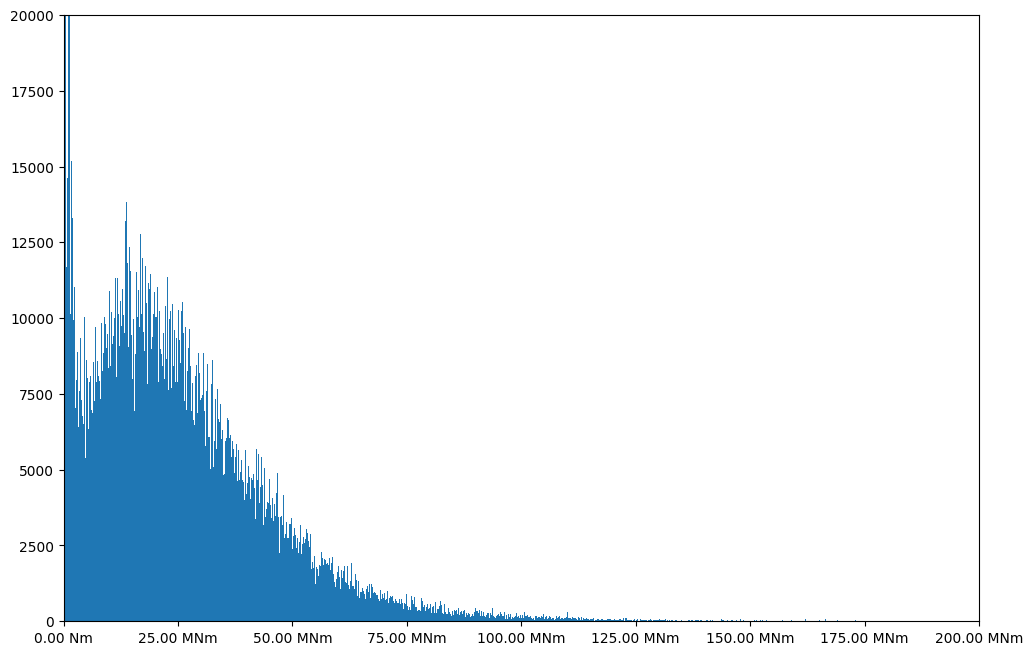

In [75]:
ranges, counts = binned_markov_hotspot.T
fig, ax = plt.subplots()
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim((0, 20e3))
plt.xlim((0, 2e8))
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sci_format(x,pos)))


In [76]:
S_test = curve.SN.fatigue_strength(N_equivalent)

In [77]:
S_test

52.642115454076695